## Optional: Installationen

In [1]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


# KI-gestützte Bilderkennung zur automatisierten Müllklassifizierung und Trennhilfe

**Modul:** Selected Topics of AI <br>
**Bearbeitet von:** Lars Gerigk (lg107), Julia Ebert (je073), Joel Starkov (js486) <br>
**Abgabe:** 28.01.2026 <br>

### Motivation 
Eine korrekte Mülltrennung stellt für viele Menschen eine Herausforderung dar. Gründe dafür sind unter anderem fehlendes Wissen über unterschiedlichen Entsorgungsregeln in verschiedenen Ländern sowie Unsicherheiten bei der Zuordnung einzelner Abfallarten. 

### Ziel 
Ziel dieses Projekts ist es daher, ein KI-gestütztes System zur automatisierten Müllklassifizierung zu entwickeln. Dieses System soll mithilfe einer Kamera den vorgehaltetenen Gegenstand visuell erfassen, analysieren und dem Nutzer unmittelbar anzeigen, in welchen Müllbehälter der Abfall korrekt entsorgt werden soll. 

### Anwendungsrahmen 
Wir wollen uns bewusst auf den typischen Müll beschränken, der im Alltag an der Hochschule der Medien (kurz: HdM) anfällt. Daher beziehen wir bei der Klassifikation an der HdM vorhandenen Entsorgungsmöglichkeiten. 
<br><br>

### Müllklassifikation
Unser Modell klassifiziert erkannte Objekte in eine der folgenden fünf Kategorien:

**Pfand:** Diese Kategorie umfasst pfandpflichtige Getränkeverpackungen. Dazu zählen insbesondere:
- Einweg-Plastikflaschen 
    - Sowohl mit als auch ohne sichtbare Pfandkennzeichnung
    - Auf Grund begrenzter Verfügbarkeit geeigneter Trainingsdaten werden zusätzlich Bilder aus Ländern ohne Pfandsystem verwendet.
- Getränkedosen 

Glasflaschen werden bewusst nicht dieser Kategorie zugeordnet, obwohl sie ebenfalls pfandpflichtig sein können. Der Grund hierfür liegt darin, dass Glasflaschen an der Hochschule der Medien nicht über den klassischen Pfandbehälter entsorgt werden.<br><br>

**Restmüll:** In diese Kategorie fallen Abfälle, die weder recycelbar sind noch einer der anderen Kategorien eindeutig zugeordnet werden können. Beispiele sind:
- Stark verschmutzte oder beschichtete Materialien
- Essensreste
- Nicht trennbare Verbundmaterialien<br><br>

**Papier:** Diese Kategorie umfasst saubere, trockene Papierprodukte, die für das Recycling geeignet sind, darunter:
- Papierblätter und Hefte
- Kartonverpackungen ohne starke Verschmutzung
- Papiertüten<br><br>

Nicht enthalten sind beschichtete oder stark verschmutzte Papiermaterialien, da diese nicht dem Papierrecycling zugeführt werden können.

**Verpackungen:** Diese Kategorie beinhaltet recyclebare Verpackungsmaterialien, zum Beispiel:
- Kunststoffverpackungen von Lebensmitteln
- Joghurtbecher, Folien, Plastikschalen<br><br>

**Sonstiges:** Für diese Kategorie sind alle Objekte vorgesehen, die:
- nicht zu den oben genannten Müllarten gehören oder
- an der HdM nicht im regulären Müll entsorgt werden dürfen

Dazu zählen unter anderem:
- Batterien und Elektroschrott
- Glasflaschen 
- Gegenstände, die kein Müll sind (z. B. Taschen, Bücher, Technik) <br><br>


Daten 
-> sollten nicht optimal sein <br>
-> verschiedene Lichtverhältnisse, Hände im Bild, Graustufenbild vs Farbbild, 

### Import von Abhängigkeiten

In [1]:
import os
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader


import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import wandb 

In [2]:
wandb.login()

wandb: Currently logged in as: joel-starkov (sltai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [10]:
random_seed = 23
torch.manual_seed(random_seed)

### Datensetanalyse

Für die Daten haben wir uns dafür entschieden ein Datenset von Kaggle zu verwenden hier die Daten von dem Datenset "Garbage Classification" von Mostafa Mohamed. Dieses ist unter dem folgenden Link zu finden: https://www.kaggle.com/datasets/mostafaabla/garbage-classification, entnommen am 23.12.2025. Um mit den Datensats besser verwenden zu können haben wir die Bilder manuell in unsere oben genannten Kategorien eingeteilt. 
Damit wir gleichverteilte Daten für unser Modell haben, haben wir zudem für die Klasse Pfand den Datensatz "Plastic Bottles in the wild Image Dataset" von Siddharth Sah vewendet. Das Datenset ist unter folgenden Link zu finden: https://www.kaggle.com/datasets/siddharthkumarsah/plastic-bottles-image-dataset, entnommen am 10.01.2025. 
Damit eine Gleichverteilung gewährleistet werden kann entnehmen wir aus jeder Datenquelle 2000 Bilder. 

Restmüll, Papier: https://www.kaggle.com/datasets/mostafaabla/garbage-classification <br>
Pfandflaschen:  https://www.kaggle.com/datasets/siddharthkumarsah/plastic-bottles-image-dataset

Kaffeebecher Url: 
https://www.kaggle.com/datasets/vencerlanz09/plastic-and-paper-cups-synthetic-image-dataset

Plastik 1:
https://www.kaggle.com/datasets/harshitkandoi7850/dataset-for-visual-plastic-type-recognition

Plastik 2:
https://www.kaggle.com/datasets/nandinibagga/plastic-images

Dosen:
https://www.kaggle.com/datasets/tarekyasser63/drinks-cans

- wir haben bilder die nicht zur Uni passen entfernt um auf 2000 zu kommen -> Scenario nicht passen
- Bilder aussortiert, Datensätze konnten wir nicht direkt so verwenden da es Pfandflaschen nur in Deutschland gibt

Zudem haben wir eigene Bilder gesammelt, die man dem Ordner xy entnehmen kann. 

Weights and Bias

### Datenaufbereitung
#### Import der Bilder

In [4]:
dataDir = "./Train-Data"

full_dataset = datasets.ImageFolder(
    root=dataDir
)

print(full_dataset)
print("Klassen: ", full_dataset.classes)


class_count = len(full_dataset.classes)
print("Anzahl Klassen: ", class_count) 

Dataset ImageFolder
    Number of datapoints: 10391
    Root location: ./Train-Data
Klassen:  ['other', 'paper', 'residual waste', 'returnable bottle', 'verpackungen']
Anzahl Klassen:  5


In [5]:
def count_classes(dataset):
    img_classes = {}
    class_names = dataset.classes

    for _, label in dataset:
        class_name = class_names[int(label)]

        if class_name not in img_classes:
            img_classes[class_name] = 0

        img_classes[class_name] += 1

    return img_classes


In [6]:
img_classes = count_classes(full_dataset)

In [7]:
def print_class_distribution(img_classes, title, xlabel, ylabel):
    plt.figure(figsize=(10,5))
    plt.bar(img_classes.keys(), img_classes.values())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

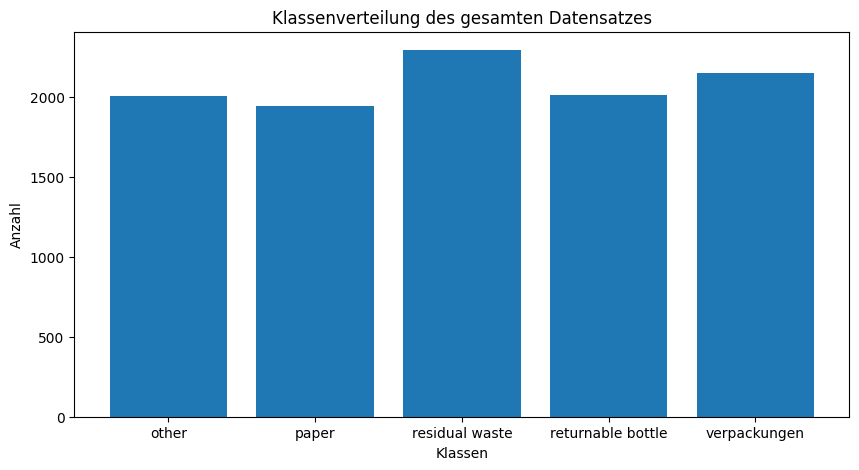

{'other': 2001, 'paper': 1941, 'residual waste': 2291, 'returnable bottle': 2013, 'verpackungen': 2145}


In [8]:
print_class_distribution(img_classes, title='Klassenverteilung des gesamten Datensatzes', xlabel='Klassen', ylabel='Anzahl')
print(img_classes)

#### Aufteilung der Daten in Trainings- und Testdaten 

In [11]:
from sklearn.utils import shuffle

trainRatio = 0.8
train_size = int(trainRatio * len(full_dataset))
test_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(random_seed)

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=generator
)

In [12]:
print("Dataset Train: ", len(train_dataset))
print("Dataset Test: ", len(test_dataset))

Dataset Train:  8312
Dataset Test:  2079


In [13]:
count_classes_train = count_classes(train_dataset.dataset)
count_classes_test = count_classes(test_dataset.dataset)

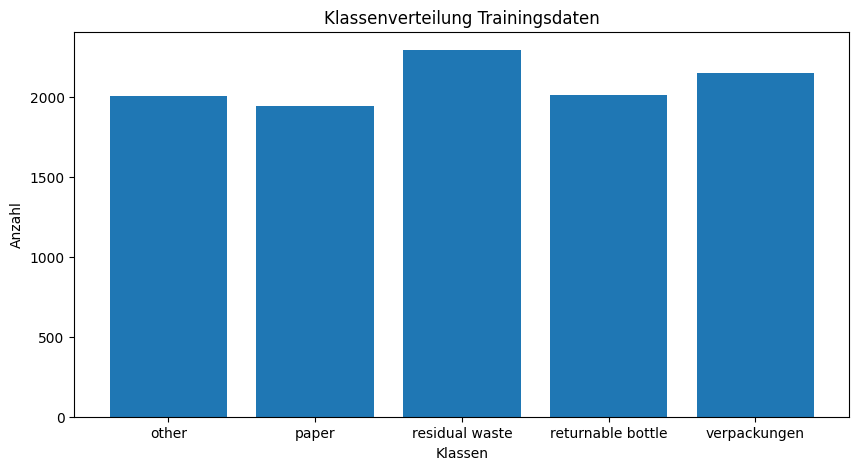

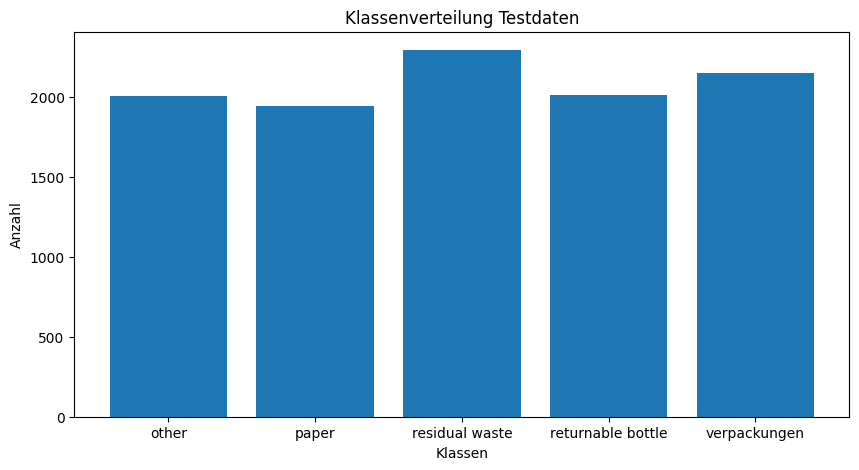

In [14]:
print_class_distribution(count_classes_train, title='Klassenverteilung Trainingsdaten', xlabel='Klassen', ylabel='Anzahl')
print_class_distribution(count_classes_test, title='Klassenverteilung Testdaten', xlabel='Klassen', ylabel='Anzahl')

!! funktion erstellen um immer 3 bilder pro Klasse zu printen 

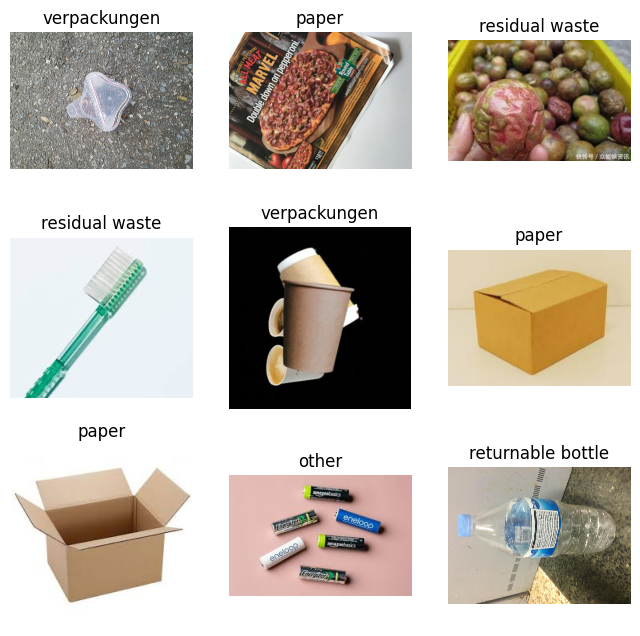

In [15]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
class_names = full_dataset.classes  

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    class_name = class_names[label]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(class_name)
    plt.imshow(img)
plt.show()

#### Transform Methoden für die Daten erstellen 

Alle Bilder in eine Größe bringen <br>
Drehen und verzerren etc. 
Ohne Farben arbeiten? 
Warum Resize? 
Warum CenterCrop? 

In [16]:
image_size = 32

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size)),
    transforms.ToTensor()
])

transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size)),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])


In [17]:
# Transform Methoden auf das Dataset anwenden
train_dataset.dataset.transform = transform_train
test_dataset.dataset.transform = transform_test

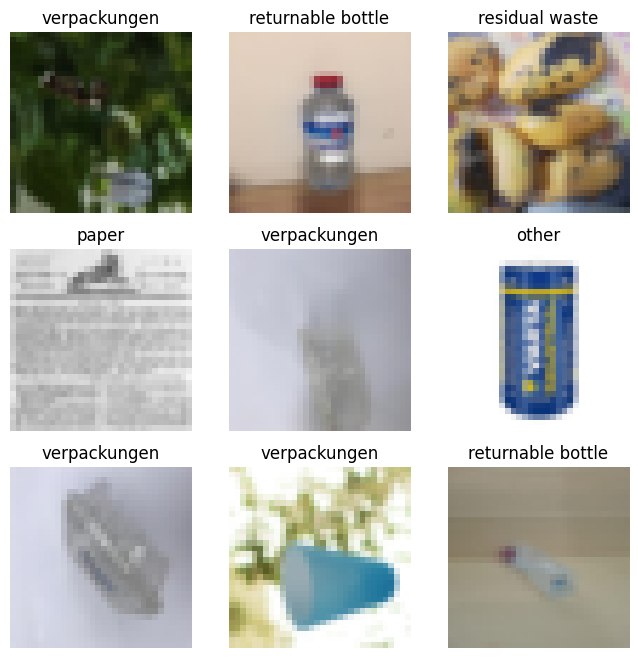

In [18]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
class_names = full_dataset.classes  

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    class_name = class_names[label]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(class_name)
    plt.imshow(img, cmap="grey")
plt.show()

##### Dataloader erstellen

In [19]:
BS = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BS,
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BS,
    shuffle=False,
    num_workers=4
)

In [20]:
imagebatch_train=next(iter(train_loader))

print("Shape: ", imagebatch_train[0].shape)
print("First image: ", imagebatch_train[1])
print("Batchsize: ", len(imagebatch_train[1]))

Shape:  torch.Size([16, 3, 32, 32])
First image:  tensor([1, 2, 3, 4, 4, 0, 3, 4, 4, 3, 4, 1, 0, 1, 3, 0])
Batchsize:  16


!!! printen

In [21]:
imagebatch_test=next(iter(test_loader))

print("Shape: ", imagebatch_test[0].shape)
print("First image: ", imagebatch_test[1])
print("Batchsize: ", len(imagebatch_test[1]))

Shape:  torch.Size([16, 3, 32, 32])
First image:  tensor([1, 3, 3, 1, 1, 2, 4, 0, 4, 0, 3, 3, 0, 1, 0, 0])
Batchsize:  16


!!! printen

## Architekturen definieren 

1. MLP 
3. CNN - Eigenen Feature Extractor und Classifier 
2. Transfer Learning <br>
    2.1. From scratch <br>
    2.2. Pretrained<br>
    2.3. Fine Tune <br>

### Multi Layer Perceptron 

In [29]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.d1 = nn.Linear(3 * image_size * image_size, 512)
        self.dropout = nn.Dropout(p=0.2)
        self.d2 = nn.Linear(512, class_count)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1) #serialize 3dim input

        x = self.d1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        raw_scores = self.d2(x)
        output_predictions = torch.softmax(raw_scores , dim=1)   

        return output_predictions 

In [30]:
model = MLP()
model = model.to(device)

images, labels = next(iter(train_loader)) 
images = images.to(device)
labels = labels.to(device)

print("batch size:", images.shape)

output_predictions = model(images)
output_predicted_label = torch.argmax(output_predictions, dim=1)

print(output_predictions)
print(output_predicted_label)

batch size: torch.Size([16, 3, 32, 32])
tensor([[0.1670, 0.2384, 0.2347, 0.1893, 0.1705],
        [0.1669, 0.2440, 0.2807, 0.1739, 0.1345],
        [0.1942, 0.2227, 0.2212, 0.1790, 0.1829],
        [0.1719, 0.2163, 0.2574, 0.1711, 0.1834],
        [0.1658, 0.2365, 0.2935, 0.1726, 0.1315],
        [0.1602, 0.2311, 0.2465, 0.2039, 0.1582],
        [0.1784, 0.2254, 0.2249, 0.2012, 0.1702],
        [0.1885, 0.2339, 0.2516, 0.1584, 0.1676],
        [0.1890, 0.2140, 0.2272, 0.1941, 0.1757],
        [0.1561, 0.2162, 0.2987, 0.1717, 0.1573],
        [0.1527, 0.2445, 0.2567, 0.1799, 0.1662],
        [0.1807, 0.2242, 0.2540, 0.1945, 0.1466],
        [0.1714, 0.2076, 0.2575, 0.2035, 0.1601],
        [0.1630, 0.2214, 0.3103, 0.1708, 0.1346],
        [0.1954, 0.2373, 0.2178, 0.1980, 0.1515],
        [0.1596, 0.1859, 0.3113, 0.1941, 0.1491]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2], device='cuda:0')


In [31]:
summary(model,input_size=(3, image_size, image_size))
print("")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
           Dropout-2                  [-1, 512]               0
            Linear-3                    [-1, 5]           2,565
Total params: 1,575,941
Trainable params: 1,575,941
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.01
Estimated Total Size (MB): 6.03
----------------------------------------------------------------



#### Define Configurations using wandb

In [32]:
config_mlp = {
    "learning_rate": 0.1,
    "batch_size": BS,
    "epochs": 15,
    "architecture": "MLP",
    "image_size": image_size,
}

!!! Warum CrossEntropyLoss und SGD

In [33]:
model = MLP()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config_mlp["learning_rate"])

#### Training
Now it’s time to train the model

!!! get_accuracy evtl in Utils

In [26]:
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    prediction=torch.max(output, 1)[1].view(target.size())
    #prediction=torch.argmax(output, 1)
    corrects = (prediction.data == target.data).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

In [35]:
train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []

wandb.init(
    project="Müll_Classification_MLP",
    config=config_mlp
)

for epoch in range(config_mlp["epochs"]):
    train_loss = 0.0
    train_accuracy = 0.0

    test_loss = 0.0
    test_accuracy = 0.0

    for i, (images, labels) in enumerate(train_loader): 
        model.train()

        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss += loss.detach().item()
        train_accuracy += get_accuracy(predictions, labels, config_mlp["batch_size"])

    train_accuracy = train_accuracy / i # Warum in den Folien acc_train=train_acc/i   und i ist 1 kleiner als len(train_loader) ?
    train_accuracies.append(train_accuracy)

    train_loss = train_loss / i
    train_losses.append(train_loss)

    for i, (images, labels) in enumerate(test_loader):
        model.eval()

        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        loss = criterion(predictions, labels)

        test_loss += loss.detach().item()
        test_accuracy += get_accuracy(predictions, labels, config_mlp["batch_size"])

    test_accuracy = test_accuracy / i
    test_accuracies.append(test_accuracy)

    test_loss = test_loss / i
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{config_mlp['epochs']}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
    
    wandb.log({
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,   
        "Test Loss": test_loss,
        "Test Accuracy": test_accuracy
    }) 

Epoch 1/15, Train Loss: 1.5649, Train Acc: 30.64%, Test Loss: 1.5768, Test Acc: 30.09%
Epoch 2/15, Train Loss: 1.5307, Train Acc: 35.42%, Test Loss: 1.5192, Test Acc: 36.29%
Epoch 3/15, Train Loss: 1.5106, Train Acc: 37.17%, Test Loss: 1.5463, Test Acc: 35.61%
Epoch 4/15, Train Loss: 1.4986, Train Acc: 39.19%, Test Loss: 1.5075, Test Acc: 38.52%
Epoch 5/15, Train Loss: 1.4863, Train Acc: 40.50%, Test Loss: 1.5361, Test Acc: 36.48%
Epoch 6/15, Train Loss: 1.4849, Train Acc: 40.38%, Test Loss: 1.5449, Test Acc: 36.39%
Epoch 7/15, Train Loss: 1.4830, Train Acc: 41.14%, Test Loss: 1.5702, Test Acc: 33.91%
Epoch 8/15, Train Loss: 1.4772, Train Acc: 41.56%, Test Loss: 1.5440, Test Acc: 35.08%
Epoch 9/15, Train Loss: 1.4708, Train Acc: 42.30%, Test Loss: 1.5213, Test Acc: 39.00%
Epoch 10/15, Train Loss: 1.4643, Train Acc: 42.79%, Test Loss: 1.4972, Test Acc: 41.09%
Epoch 11/15, Train Loss: 1.4653, Train Acc: 43.05%, Test Loss: 1.4900, Test Acc: 41.13%
Epoch 12/15, Train Loss: 1.4575, Train Ac

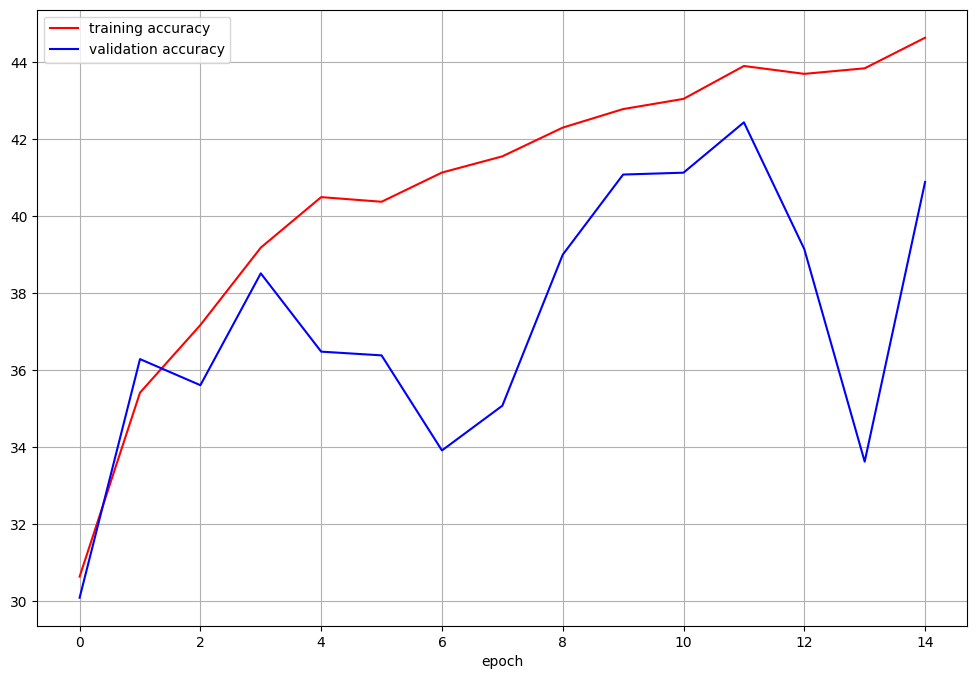

In [36]:
plt.figure(figsize=(12,8))
plt.plot(range(config_mlp["epochs"]),train_accuracies,"r",label="training accuracy")
plt.plot(range(config_mlp["epochs"]),test_accuracies,"b",label="validation accuracy")
plt.xlabel("epoch")
plt.grid(True)
plt.legend()
plt.show()

#### CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(2048, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, class_count)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = F.softmax(x, dim=1)
        return x

In [23]:
net = Net().to(device)
summary(net, input_size=(3, image_size, image_size), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           9,248
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
            Linear-6                   [-1, 64]           8,256
            Linear-7                    [-1, 5]             325
Total params: 280,997
Trainable params: 280,997
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 1.07
Estimated Total Size (MB): 1.48
----------------------------------------------------------------


In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5,)

In [27]:
num_epochs=30
train_acc_list=[]
test_acc_list=[]
## train the model
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    test_running_loss = 0.0
    test_acc = 0.0

    ## commence training
    #model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):
        net.train()
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = net(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BS)
    
    #print(i,train_acc)
    acc_train=train_acc/i
    loss_train=train_running_loss / i
    train_acc_list.append(acc_train)
    
    for i, (images, labels) in enumerate(test_loader):
        net.eval()
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = net(images)
        loss = criterion(predictions, labels)

        test_running_loss += loss.detach().item()
        test_acc += get_accuracy(predictions, labels, BS)
    
    #print(i,train_acc)
    acc_test=test_acc/i
    loss_test=test_running_loss / i
    test_acc_list.append(acc_test)
    
    print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.2f | Val. Loss: %.4f | Val. Accuracy: %.2f' \
          %(epoch,loss_train,acc_train,loss_test,acc_test)) 

Epoch: 0 | Train Loss: 1.6013 | Train Accuracy: 23.11 | Val. Loss: 1.5776 | Val. Accuracy: 31.40
Epoch: 1 | Train Loss: 1.5121 | Train Accuracy: 32.43 | Val. Loss: 1.4971 | Val. Accuracy: 33.19
Epoch: 2 | Train Loss: 1.4241 | Train Accuracy: 38.95 | Val. Loss: 1.3946 | Val. Accuracy: 40.89
Epoch: 3 | Train Loss: 1.3400 | Train Accuracy: 45.23 | Val. Loss: 1.3990 | Val. Accuracy: 42.59
Epoch: 4 | Train Loss: 1.2848 | Train Accuracy: 48.53 | Val. Loss: 1.3834 | Val. Accuracy: 43.90
Epoch: 5 | Train Loss: 1.2304 | Train Accuracy: 51.34 | Val. Loss: 1.2392 | Val. Accuracy: 51.74
Epoch: 6 | Train Loss: 1.1753 | Train Accuracy: 54.38 | Val. Loss: 1.2186 | Val. Accuracy: 54.12
Epoch: 7 | Train Loss: 1.1423 | Train Accuracy: 56.02 | Val. Loss: 1.2808 | Val. Accuracy: 48.50
Epoch: 8 | Train Loss: 1.1036 | Train Accuracy: 58.48 | Val. Loss: 1.2168 | Val. Accuracy: 53.78
Epoch: 9 | Train Loss: 1.0714 | Train Accuracy: 58.74 | Val. Loss: 1.1268 | Val. Accuracy: 58.33
Epoch: 10 | Train Loss: 1.0458

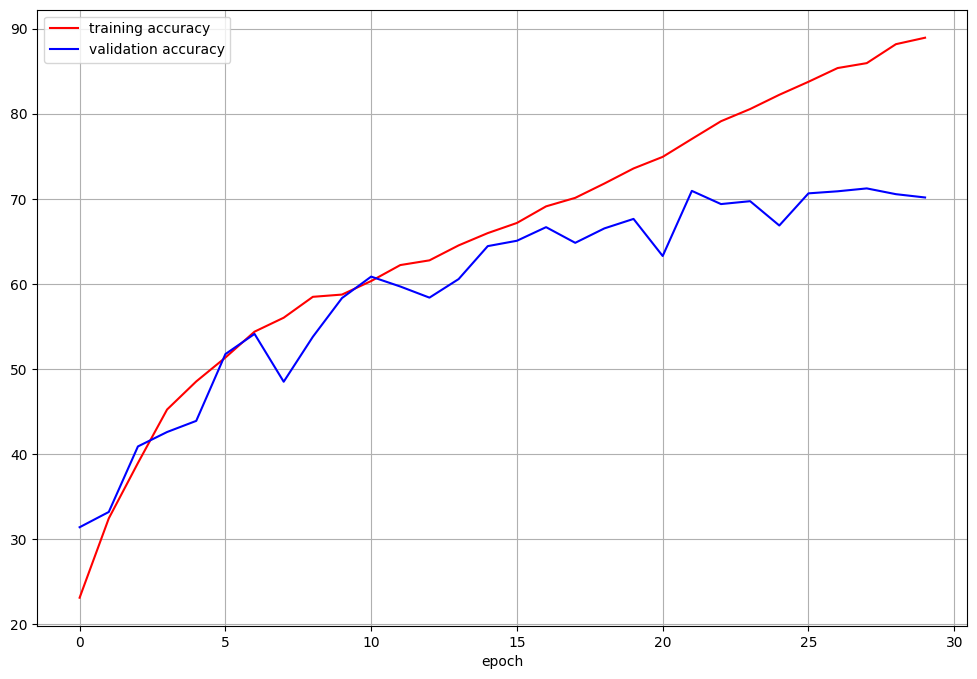

In [28]:
plt.figure(figsize=(12,8))
plt.plot(range(num_epochs),train_acc_list,"r",label="training accuracy")
plt.plot(range(num_epochs),test_acc_list,"b",label="validation accuracy")
plt.xlabel("epoch")
plt.grid(True)
plt.legend()
plt.show()

In [29]:
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        self.drop=nn.Dropout2d(0.3)
        self.dropfc=nn.Dropout(0.3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512*2*2, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.drop(self.conv1(x)))))
        x = self.pool(F.relu(self.bn2(self.drop(self.conv2(x)))))
        x = self.pool(F.relu(self.bn3(self.drop(self.conv3(x)))))
        x = self.pool(F.relu(self.bn4(self.drop(self.conv4(x)))))
        x = x.view(-1, 512*2*2)
        x = F.relu(self.dropfc(self.fc1(x)))
        x = self.fc2(x)
        return x

In [30]:
net2=BetterNet().to(device)
summary(net2,input_size=(3, 32, 32), device=device)
print("")
#net2=Net3()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         Dropout2d-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         Dropout2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
        Dropout2d-10            [-1, 256, 8, 8]               0
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
        Dropout2d-14            [-1, 51

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)
#batch_size=128

In [32]:
num_epochs=30
train_acc_list=[]
test_acc_list=[]
## train the model
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    test_running_loss = 0.0
    test_acc = 0.0

    ## commence training
    #model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):
        net2.train()
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = net2(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BS)
    
    #print(i,train_acc)
    acc_train=train_acc/i
    loss_train=train_running_loss / i
    train_acc_list.append(acc_train)
    
    for i, (images, labels) in enumerate(test_loader):
        net2.eval()
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = net2(images)
        loss = criterion(predictions, labels)

        test_running_loss += loss.detach().item()
        test_acc += get_accuracy(predictions, labels, BS)
    
    #print(i,train_acc)
    acc_test=test_acc/i
    loss_test=test_running_loss / i
    test_acc_list.append(acc_test)
    
    print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.2f | Val. Loss: %.4f | Val. Accuracy: %.2f' \
          %(epoch,loss_train,acc_train,loss_test,acc_test)) 

Epoch: 0 | Train Loss: 1.4686 | Train Accuracy: 39.82 | Val. Loss: 1.5843 | Val. Accuracy: 34.93
Epoch: 1 | Train Loss: 1.3039 | Train Accuracy: 48.07 | Val. Loss: 1.3792 | Val. Accuracy: 41.91
Epoch: 2 | Train Loss: 1.2533 | Train Accuracy: 50.93 | Val. Loss: 1.2858 | Val. Accuracy: 49.22
Epoch: 3 | Train Loss: 1.2151 | Train Accuracy: 52.55 | Val. Loss: 1.6536 | Val. Accuracy: 42.97
Epoch: 4 | Train Loss: 1.1671 | Train Accuracy: 56.08 | Val. Loss: 1.1927 | Val. Accuracy: 52.23
Epoch: 5 | Train Loss: 1.1304 | Train Accuracy: 56.68 | Val. Loss: 1.2919 | Val. Accuracy: 51.70
Epoch: 6 | Train Loss: 1.1138 | Train Accuracy: 58.15 | Val. Loss: 1.2171 | Val. Accuracy: 51.84
Epoch: 7 | Train Loss: 1.0852 | Train Accuracy: 58.86 | Val. Loss: 1.2652 | Val. Accuracy: 52.76
Epoch: 8 | Train Loss: 1.0534 | Train Accuracy: 60.78 | Val. Loss: 1.0451 | Val. Accuracy: 59.84
Epoch: 9 | Train Loss: 1.0326 | Train Accuracy: 61.10 | Val. Loss: 1.1057 | Val. Accuracy: 58.28
Epoch: 10 | Train Loss: 1.0032

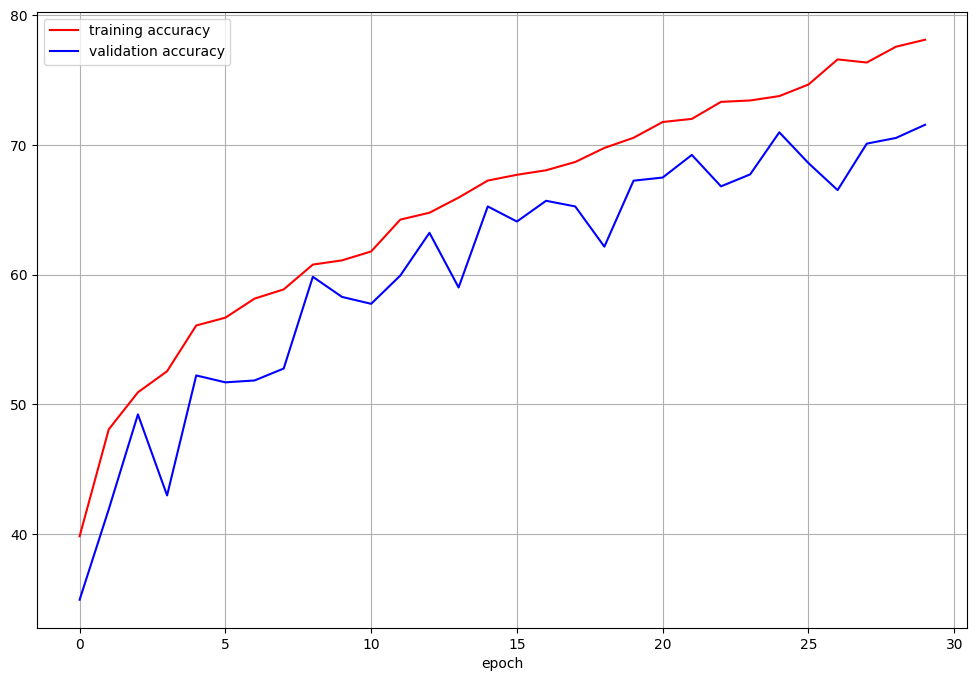

In [33]:
plt.figure(figsize=(12,8))
plt.plot(range(num_epochs),train_acc_list,"r",label="training accuracy")
plt.plot(range(num_epochs),test_acc_list,"b",label="validation accuracy")
plt.xlabel("epoch")
plt.grid(True)
plt.legend()
plt.show()